In [1]:
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from superfv import (
    EulerSolver,
    OutputLoader,
    plot_1d_slice,
)
from superfv.initial_conditions import square

In [2]:
N = 64
T = 1.0
gamma = 1.4

base = "/scratch/gpfs/jp7427/out/square2d/"
overwrite = []

configs = {
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="PP2D",
        SED=True,
    ),
    "ZS3": dict(
        GL=True,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        ZS=True,
        include_corners=True,
        adaptive_dt=False,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "ZS3-T": dict(
        GL=False,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        ZS=True,
        include_corners=True,
        adaptive_dt=False,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3(1)": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        absolute_dmp=False,
        include_corners=True,
        NAD_rtol=1,
        NAD_atol=1e-8,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3(1e-1)": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        absolute_dmp=False,
        include_corners=True,
        NAD_rtol=1e-1,
        NAD_atol=1e-8,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3(1e-2)": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        absolute_dmp=False,
        include_corners=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3(1e-5)": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        absolute_dmp=False,
        include_corners=True,
        NAD_rtol=1e-5,
        NAD_atol=1e-8,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
}

sims = {}
data = []
for (name, config), rho_min in product(
    configs.items(), [1e-1, 1e-2, 1e-3, 1e-4, 1e-6, 1e-8]
):
    path = base + name + f"/rho_min_{rho_min:.0e}/"
    if overwrite != "all":
        if name not in overwrite:
            try:
                # sim = OutputLoader(path)
                # sims[name] = sim
                with open(path + "status.txt", "r") as f:
                    status = f.read().strip()
                data.append(
                    dict(
                        name=name,
                        rho_min=rho_min,
                        passed={"passed": True, "failed": False}.get(status, None),
                    )
                )

                print(f'Read status from "{path}"')
                continue
            except FileNotFoundError:
                pass

    print(f"Running {name}...")
    sim = EulerSolver(
        ic=partial(square, vx=2, vy=1, bounds=(rho_min, 1.0), P=1e-5),
        gamma=gamma,
        nx=N,
        ny=N,
        cupy=True,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True, path=path, overwrite=True)
        else:
            sim.run(
                T,
                q_max=2,
                allow_overshoot=True,
                path=path,
                overwrite=True,
            )
        sims[name] = sim
        with open(path + "status.txt", "w") as f:
            f.write("passed")
        data.append(dict(name=name, rho_min=rho_min, passed=True))
    except Exception as e:
        print(f"Failed: {e}")
        with open(path + "status.txt", "w") as f:
            f.write("failed")
        data.append(dict(name=name, rho_min=rho_min, passed=False))
        continue
df = pd.DataFrame(data)

Running MUSCL-Hancock...
Step #242 @ t=1.00e+00 | dt=4.13e-03 | min(rho)=1.00e-01, min(P)=1.00e-05 | (done)                  
Running MUSCL-Hancock...
Step #246 @ t=1.00e+00 | dt=4.07e-03 | min(rho)=1.00e-02, min(P)=1.00e-05 | (done)                  
Running MUSCL-Hancock...
Step #259 @ t=1.00e+00 | dt=3.86e-03 | min(rho)=1.00e-03, min(P)=1.00e-05 | (done)                  
Running MUSCL-Hancock...
Step #300 @ t=1.00e+00 | dt=3.33e-03 | min(rho)=1.00e-04, min(P)=1.00e-05 | (done)                  
Running MUSCL-Hancock...
Step #839 @ t=1.00e+00 | dt=1.19e-03 | min(rho)=1.00e-06, min(P)=1.00e-05 | (done)                  
Running MUSCL-Hancock...
Step #6704 @ t=1.00e+00 | dt=1.60e-04 | min(rho)=9.98e-09, min(P)=9.89e-06 | (done)                 
Read status from "/scratch/gpfs/jp7427/out/square2d/ZS3/rho_min_1e-01/"
Read status from "/scratch/gpfs/jp7427/out/square2d/ZS3/rho_min_1e-02/"
Read status from "/scratch/gpfs/jp7427/out/square2d/ZS3/rho_min_1e-03/"
Read status from "/scratch/g

In [3]:
df

,name,rho_min,passed
0,MUSCL-Hancock,1.000000e-01,True
1,MUSCL-Hancock,1.000000e-02,True
2,MUSCL-Hancock,1.000000e-03,True
3,MUSCL-Hancock,1.000000e-04,True
4,MUSCL-Hancock,1.000000e-06,True
5,MUSCL-Hancock,1.000000e-08,True
6,ZS3,1.000000e-01,True
7,ZS3,1.000000e-02,True
8,ZS3,1.000000e-03,True
9,ZS3,1.000000e-04,True


In [4]:
df.pivot(index="rho_min", columns="name", values="passed").loc[
    :,
    ["MUSCL-Hancock", "ZS3", "ZS3-T", "MM3(1)", "MM3(1e-1)", "MM3(1e-2)", "MM3(1e-5)"],
].sort_index(ascending=False)

name,MUSCL-Hancock,ZS3,ZS3-T,MM3(1),MM3(1e-1),MM3(1e-2),MM3(1e-5)
rho_min,,,,,,,
1.000000e-01,True,True,True,True,True,True,True
1.000000e-02,True,True,True,True,True,True,True
1.000000e-03,True,True,False,True,True,True,True
1.000000e-04,True,True,False,False,False,True,True
1.000000e-06,True,True,False,False,False,False,False
1.000000e-08,True,True,False,False,False,False,False


Successfully read simulation output from "/scratch/gpfs/jp7427/out/square2d/MUSCL-Hancock/rho_min_1e-08"


/home/jp7427/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(


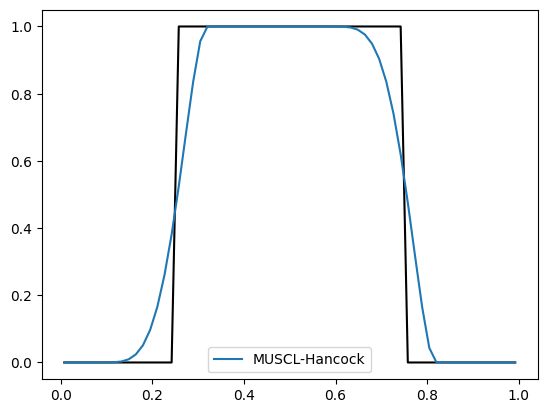

In [5]:
fig, ax = plt.subplots()

sim = OutputLoader("/scratch/gpfs/jp7427/out/square2d/MUSCL-Hancock/rho_min_1e-08")

plot_1d_slice(sim, ax, "rho", y=0.5, cell_averaged=True, t=0, color="k")
plot_1d_slice(sim, ax, "rho", y=0.5, cell_averaged=True, label="MUSCL-Hancock")

ax.legend()

Successfully read simulation output from "/scratch/gpfs/jp7427/out/square2d/MM3(1e-1)/rho_min_1e-02"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/square2d/MM3(1e-2)/rho_min_1e-02"


/home/jp7427/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:38: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.492188
  warnings.warn(


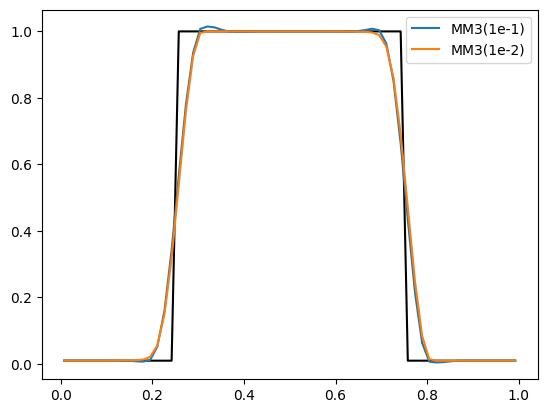

In [6]:
fig, ax = plt.subplots()

sim1 = OutputLoader("/scratch/gpfs/jp7427/out/square2d/MM3(1e-1)/rho_min_1e-02")
sim2 = OutputLoader("/scratch/gpfs/jp7427/out/square2d/MM3(1e-2)/rho_min_1e-02")

plot_1d_slice(sim1, ax, "rho", y=0.5, cell_averaged=True, t=0, color="k")
plot_1d_slice(sim1, ax, "rho", y=0.5, cell_averaged=True, label="MM3(1e-1)")
plot_1d_slice(sim2, ax, "rho", y=0.5, cell_averaged=True, label="MM3(1e-2)")

ax.legend()